# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error #, accuracy_score ,f1_score,confusion_matrix, classification_report
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

# Helper Functions

In [2]:
def remove_value(data, column_name, string_to_replace, replace_value='', change_dataType=True):
  data[column_name] = data[column_name].str.replace(string_to_replace, replace_value)
  if change_dataType:
    data[column_name] = data[column_name].astype(int)

In [3]:
def Feature_Encoder(X, cols):
    for c in cols:
        lbl = LabelEncoder()
        lbl.fit(list(X[c].values))
        X[c] = lbl.transform(list(X[c].values))
    return X

In [4]:
# Extract number from string
def extract_number(number_string, mode_value=0):
    if isinstance(number_string, str):
        match = re.search(r'\d+', number_string)  # Find the first occurrence of one or more digits
        if match:
            return int(match.group())  # Convert the matched digits to an integer
        else:
            return mode_value  # If no digits found, return 0
    else:
        return number_string

In [5]:
# def featureScaling(X, a, b):
#     X = np.array(X)
#     Normalized_X = np.zeros((X.shape[0], X.shape[1]))
#     for i in range(X.shape[1]):
#         Normalized_X[:, i] = ((X[:, i] - min(X[:, i])) / (max(X[:, i]) - min(X[:, i]))) * (b - a) + a
#     return Normalized_X

In [6]:
def execute_model(model, X_train, Y_train, X_test, Y_test, model_name):
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(Y_train, Y_train_pred)
    print(f"{model_name}:\n Training MSE: {train_mse}")

    test_mse = mean_squared_error(Y_test, Y_test_pred)
    print(f" Testing MSE: {test_mse}")

    train_accuracy = accuracy_score(Y_train, Y_train_pred)
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    print(f" Training Accuracy: {train_accuracy}")
    print(f" Testing Accuracy: {test_accuracy}")
    draw(Y_test, Y_test_pred, model_name)

In [7]:
def draw(Y_test, Y_test_pred, model_name):

    plt.figure
    plt.subplot(2,1,1)
    plt.scatter(range(len(Y_test)), Y_test, color='blue', label='Actual')

    plt.subplot(2,1,2)
    plt.scatter(range(len(Y_test_pred)), Y_test_pred, color='red', label=model_name)

    plt.xlabel('Data Points')
    plt.ylabel('Target Variable')
    plt.title('Regression Model Predictions')
    plt.legend()
    plt.show()

# Read Data

In [8]:
data = pd.read_csv('ElecDeviceRatingPrediction_Milestone2.csv')
# print(data.head())

# Preprocessing

In [9]:
# Calculate mode for each column
mode_values = data.mode()

mode_dict = {}

for col in mode_values.columns:
    mode_dict[col] = mode_values[col][0]

print(mode_dict)

{'brand': 'ASUS', 'processor_brand': 'Intel', 'processor_name': 'Core i5', 'processor_gnrtn': '11th', 'ram_gb': '8 GB', 'ram_type': 'DDR4', 'ssd': '512 GB', 'hdd': '0 GB', 'os': '64-bit Windows', 'graphic_card_gb': '0 GB', 'weight': 'Casual', 'warranty': '1 year', 'Touchscreen': 'No', 'msoffice': 'No', 'Price': 64990, 'rating': 'Good Rating', 'Number of Ratings': 0, 'Number of Reviews': 0}


## Null Values

In [10]:
print(data.isna().sum())

brand                0
processor_brand      0
processor_name       0
processor_gnrtn      0
ram_gb               0
ram_type             0
ssd                  0
hdd                  0
os                   0
graphic_card_gb      0
weight               0
warranty             0
Touchscreen          0
msoffice             0
Price                0
rating               0
Number of Ratings    0
Number of Reviews    0
dtype: int64


## Features

In [11]:
# processor_gnrtn
data['processor_gnrtn'].value_counts()
mode_value = data['processor_gnrtn'].mode()[0]
data['processor_gnrtn'].replace('Not Available', mode_value, inplace = True)
remove_value(data, 'processor_gnrtn', 'th')

In [12]:
# ram_gb
remove_value(data,'ram_gb' ,' GB')

In [13]:
# ssd
remove_value(data,'ssd' ,' GB')

In [14]:
# hdd
remove_value(data,'hdd' ,' GB')

In [15]:
# os
data[['os_bits', 'os_type']] = data['os'].str.split(' ', expand=True)
data = data.drop('os', axis = 1)
print('os_bits', ":", data['os_bits'].unique())
print('os_type', ":", data['os_type'].unique())
remove_value(data,'os_bits' ,'-bit')

os_bits : ['64-bit' '32-bit']
os_type : ['Windows' 'DOS' 'Mac']


In [16]:
# graphic_card_gb
remove_value(data,'graphic_card_gb' ,' GB')

In [17]:
# warranty
remove_value(data,'warranty' ,'No warranty', '0', False)
remove_value(data,'warranty' ,' years', '', False)
remove_value(data,'warranty' ,' year')

In [18]:
# Touchscreen
remove_value(data,'Touchscreen' ,'No', '0', False)
remove_value(data,'Touchscreen' ,'Yes', '1')

In [19]:
# msoffice
remove_value(data,'msoffice' ,'No', '0', False)
remove_value(data,'msoffice' ,'Yes', '1')

In [20]:
# rating
rating_performance_mapping = {
    'Bad Rating': 0,
    'Good Rating': 1
}

data['rating'] = data['rating'].map(rating_performance_mapping)

In [21]:
# ram_type
ram_performance_mapping = {
    'LPDDR4X': 5,
    'LPDDR4': 4,
    'DDR4': 3,
    'DDR3': 2,
    'DDR5': 6,
    'LPDDR3': 1
}

data['ram_type'] = data['ram_type'].map(ram_performance_mapping)
# data['ram_type'].value_counts()

In [22]:
# weight
weight = {
    'Casual':2,
    'ThinNlight':1,
    'Gaming':3,
}
data['weight'] = data['weight'].map(weight)

In [23]:
# brand , processor_name
encode_cols = ('brand', 'processor_name')
data = Feature_Encoder(data, encode_cols)

In [24]:
# processor_brand
one_hot_encoded = pd.get_dummies(data['processor_brand'])
one_hot_encoded = one_hot_encoded.astype(int)

data = data.drop('processor_brand', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

In [25]:
# os_type
one_hot_encoded = pd.get_dummies(data['os_type'])
one_hot_encoded = one_hot_encoded.astype(int)

data = data.drop('os_type', axis = 1)
data = pd.concat([data, one_hot_encoded], axis=1)

In [26]:
# Replace target column
rating_col = data['rating']
data = data.drop('rating', axis = 1)
data = pd.concat([data, rating_col], axis=1)

## Outliers

<Axes: >

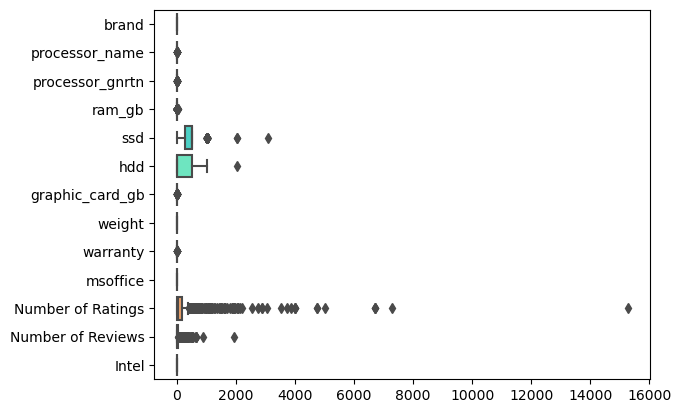

In [27]:
columns_to_exclude = ['ram_type', 'Touchscreen', 'os_bits', 'AMD', 'M1', 'DOS', 'Mac', 'Windows', 'rating','Price']
data_filtered = data.drop(columns=columns_to_exclude)

# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

In [28]:
Q1 = data.iloc[:,:-1].quantile(0.25)
Q3 = data.iloc[:,:-1].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

s = ['ram_type' ,'Touchscreen', 'os_bits' , 'AMD' , 'M1' , 'DOS' , 'Mac' , 'Windows' ]

# Replace the outliers with lower_bound or upper_bound values
for col in data.iloc[:,:-1]:
    if col not in s:
        data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
        data.loc[data[col] > upper_bound[col], col] = upper_bound[col]


print(f"lower_bound = {dict(lower_bound)}")
print(f"upper_bound = {dict(upper_bound)}")

lower_bound = {'brand': -5.0, 'processor_name': -2.5, 'processor_gnrtn': 8.5, 'ram_gb': -2.0, 'ram_type': 3.0, 'ssd': -128.0, 'hdd': -768.0, 'graphic_card_gb': -3.0, 'weight': -0.5, 'warranty': -1.5, 'Touchscreen': 0.0, 'msoffice': -1.5, 'Price': -19869.0, 'Number of Ratings': -231.0, 'Number of Reviews': -29.25, 'os_bits': 64.0, 'AMD': 0.0, 'Intel': -1.5, 'M1': 0.0, 'DOS': 0.0, 'Mac': 0.0, 'Windows': 1.0}
upper_bound = {'brand': 11.0, 'processor_name': 9.5, 'processor_gnrtn': 12.5, 'ram_gb': 14.0, 'ram_type': 3.0, 'ssd': 896.0, 'hdd': 1280.0, 'graphic_card_gb': 5.0, 'weight': 3.5, 'warranty': 2.5, 'Touchscreen': 0.0, 'msoffice': 2.5, 'Price': 155675.0, 'Number of Ratings': 385.0, 'Number of Reviews': 48.75, 'os_bits': 64.0, 'AMD': 0.0, 'Intel': 2.5, 'M1': 0.0, 'DOS': 0.0, 'Mac': 0.0, 'Windows': 1.0}


C:\Users\20115\AppData\Local\Temp\ipykernel_6032\978433476.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-2.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
C:\Users\20115\AppData\Local\Temp\ipykernel_6032\978433476.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '8.5' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[col], col] = lower_bound[col]
C:\Users\20115\AppData\Local\Temp\ipykernel_6032\978433476.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '-0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[data[col] < lower_bound[col],

<Axes: >

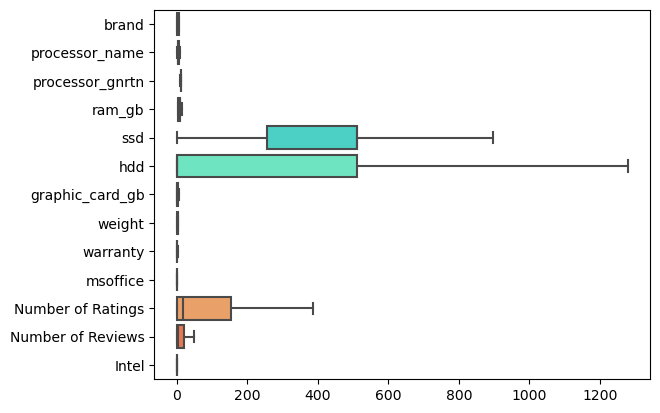

In [29]:
# sns.boxplot(data=data,palette='rainbow',orient='h')
data_filtered = data.drop(columns=columns_to_exclude)

plt.figure()
# Create the box plot with the modified data
sns.boxplot(data=data_filtered, palette='rainbow', orient='h')

## Feature selection

### Correlation

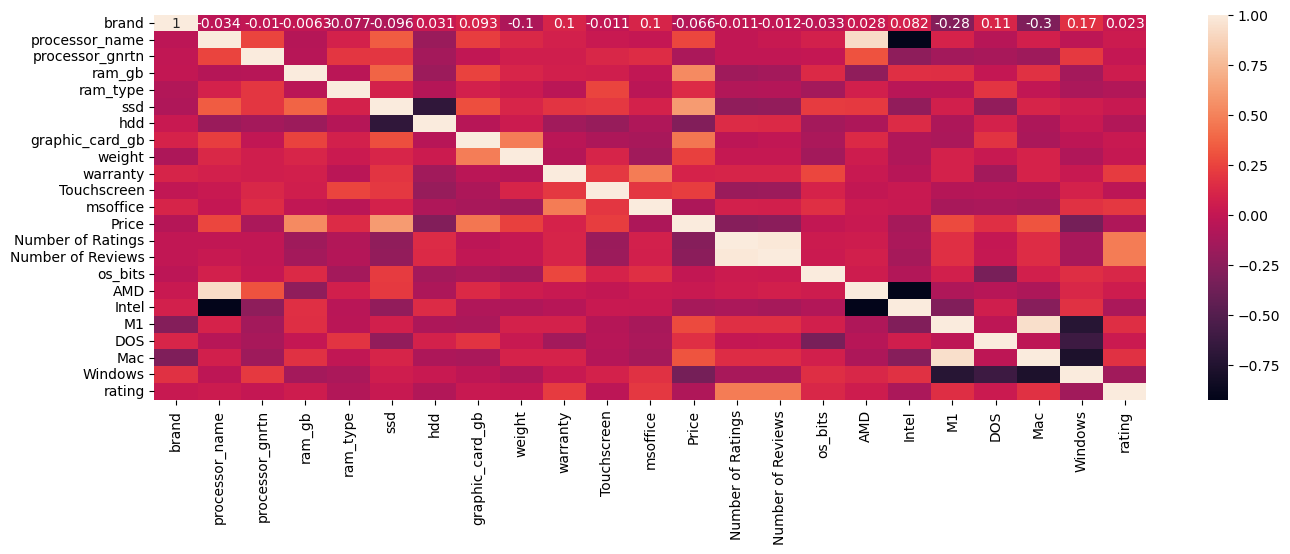

rating               1.000000
Number of Reviews    0.469883
Number of Ratings    0.469399
warranty             0.214187
msoffice             0.200001
Mac                  0.166976
M1                   0.155857
os_bits              0.118402
AMD                  0.049768
ram_gb               0.046712
processor_name       0.043981
DOS                  0.033601
graphic_card_gb      0.029356
brand                0.022819
ssd                  0.021247
weight               0.014623
processor_gnrtn      0.000854
Touchscreen         -0.029731
hdd                 -0.076796
ram_type            -0.081284
Price               -0.096768
Intel               -0.107747
Windows             -0.153616
Name: rating, dtype: float64


In [30]:
corr_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix, annot=True)
plt.show()

print(corr_matrix["rating"].sort_values(ascending=False))

In [31]:
top_feature = corr_matrix.index[abs(corr_matrix['rating']) > 0.1]
print("Top features: ", top_feature)

Top features:  Index(['warranty', 'msoffice', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'Intel', 'M1', 'Mac', 'Windows', 'rating'],
      dtype='object')


In [32]:
print("Features after preprocessing:\n")
for col in data.columns:
  if(col == "Price" or col == "Number of Ratings" or col == "Number of Reviews"):
    continue
  print(col, ":", data[col].unique(), data[col].dtype)

Features after preprocessing:

brand : [1 5 4 0 3 7 6 2] int32
processor_name : [6.  2.  0.  1.  9.  5.  8.  3.  7.  9.5 4. ] float64
processor_gnrtn : [11.  10.   8.5 12.   9. ] float64
ram_gb : [ 4  8 14] int32
ram_type : [5 4 3 2 6 1] int64
ssd : [  0 256 512 896 128] int32
hdd : [ 512    0 1024 1280] int32
graphic_card_gb : [0 4 2 5] int32
weight : [2. 1. 3.] float64
warranty : [0.  1.  2.5 2. ] float64
Touchscreen : [0 1] int32
msoffice : [0. 1.] float64
os_bits : [64 32] int32
AMD : [0 1] int32
Intel : [1. 0.] float64
M1 : [0 1] int32
DOS : [0 1] int32
Mac : [0 1] int32
Windows : [1 0] int32
rating : [0 1] int64


# Models

## Split Data

In [33]:
X = data.iloc[:, :-1]
Y = data['rating']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=70)

## Feature Selection -- Chi-Squared 

In [34]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=22)
X_train_selected = selector.fit_transform(X_train, Y_train)
X_test_selected = selector.transform(X_test)

selected_indices =  selector.get_support(indices=True)
print(selected_indices)
print("Selected features names:", data.columns[selected_indices])

X_train = X_train.iloc[:, selected_indices]
X_test = X_test.iloc[:, selected_indices]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Selected features names: Index(['brand', 'processor_name', 'processor_gnrtn', 'ram_gb', 'ram_type',
       'ssd', 'hdd', 'graphic_card_gb', 'weight', 'warranty', 'Touchscreen',
       'msoffice', 'Price', 'Number of Ratings', 'Number of Reviews',
       'os_bits', 'AMD', 'Intel', 'M1', 'DOS', 'Mac', 'Windows'],
      dtype='object')


## Logisitc Regression

Logistic Regression:
 Training MSE: 0.23529411764705882
 Testing MSE: 0.19310344827586207
 Training Accuracy: 0.7647058823529411
 Testing Accuracy: 0.8068965517241379


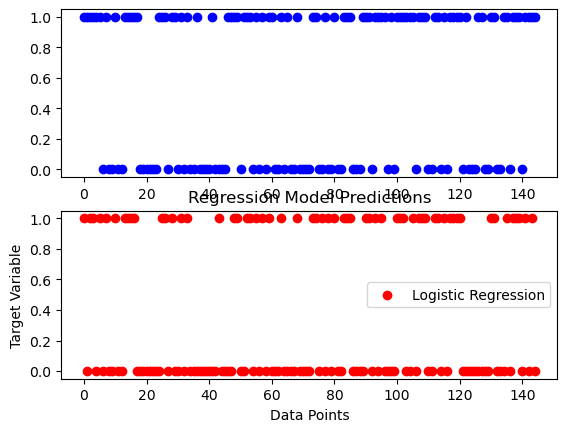

In [35]:
logistic_regression_model = linear_model.LogisticRegression()
execute_model(logistic_regression_model, X_train, Y_train, X_test, Y_test, "Logistic Regression")

## SVM

SVM:
 Training MSE: 0.43252595155709345
 Testing MSE: 0.35172413793103446
 Training Accuracy: 0.5674740484429066
 Testing Accuracy: 0.6482758620689655


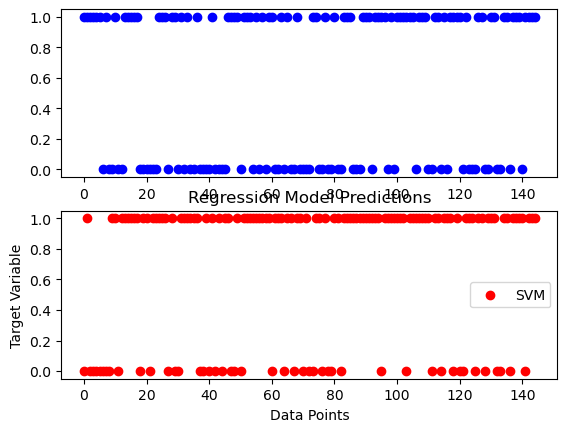

In [36]:
from sklearn import svm
svm_model = svm.SVC()
execute_model(svm_model, X_train, Y_train, X_test, Y_test, "SVM")

## Decision Tree

Decision Tree Classifier:
 Training MSE: 0.0726643598615917
 Testing MSE: 0.10344827586206896
 Training Accuracy: 0.9273356401384083
 Testing Accuracy: 0.896551724137931


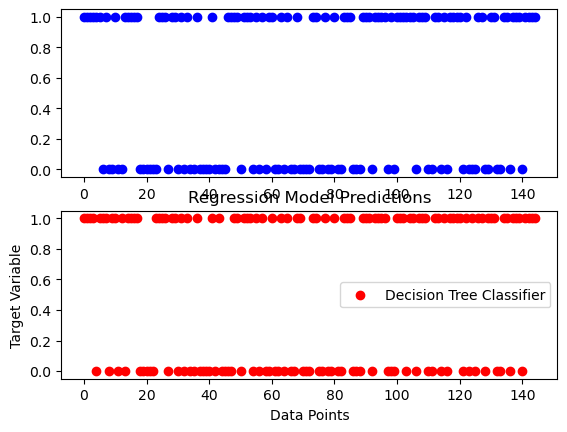

In [37]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model = DecisionTreeClassifier(max_depth=5)
execute_model(decision_tree_model, X_train, Y_train, X_test, Y_test, "Decision Tree Classifier")

## KNN

KNN:
 Training MSE: 0.16608996539792387
 Testing MSE: 0.33793103448275863
 Training Accuracy: 0.8339100346020761
 Testing Accuracy: 0.6620689655172414


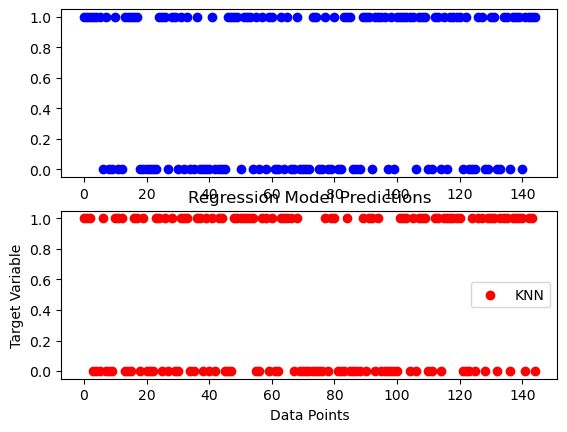

In [38]:
knn_model = KNeighborsClassifier(n_neighbors=3)
execute_model(knn_model, X_train, Y_train, X_test, Y_test, "KNN")

## Random Forest

Random Forest:
 Training MSE: 0.13667820069204153
 Testing MSE: 0.12413793103448276
 Training Accuracy: 0.8633217993079585
 Testing Accuracy: 0.8758620689655172


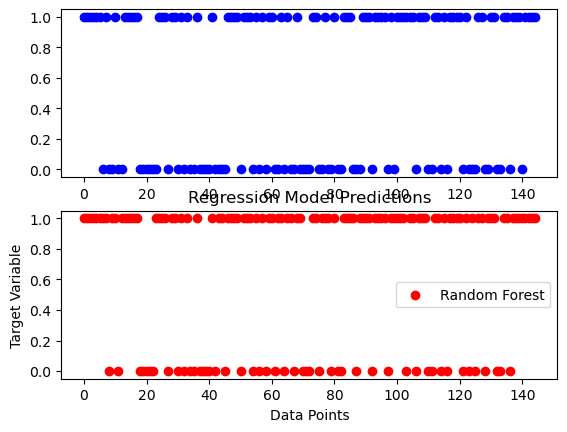

In [39]:
random_forest_model = RandomForestClassifier(max_depth =  2, n_estimators = 3)
execute_model(random_forest_model, X_train, Y_train, X_test, Y_test, "Random Forest")

## XGBoost

XGBoost:
 Training MSE: 0.44982698961937717
 Testing MSE: 0.4413793103448276
 Training Accuracy: 0.5501730103806228
 Testing Accuracy: 0.5586206896551724


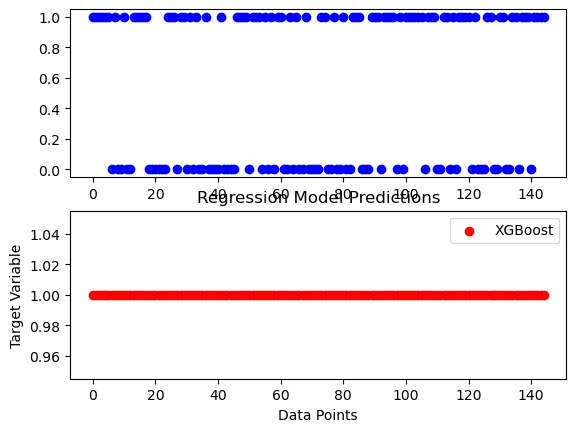

In [40]:
XGBoost_model = XGBClassifier(learning_rate =  0.01, max_depth =  2, n_estimators = 2)
execute_model(XGBoost_model, X_train, Y_train, X_test, Y_test, "XGBoost")

## Ensemble Learning - Voting

ensemble voting:
 Training MSE: 0.10899653979238755
 Testing MSE: 0.12413793103448276
 Training Accuracy: 0.8910034602076125
 Testing Accuracy: 0.8758620689655172


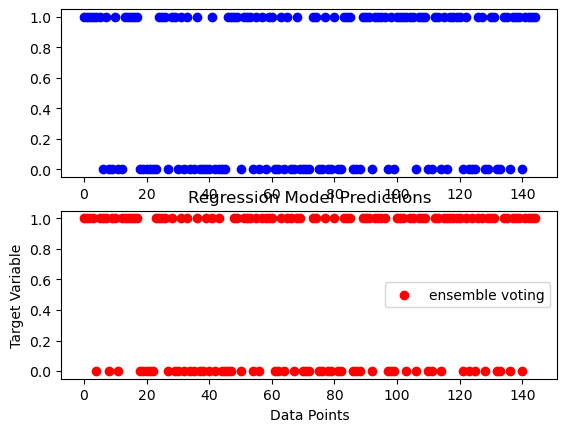

In [41]:
from sklearn.ensemble import VotingClassifier

ensemble_voting_model=VotingClassifier(estimators= [('KNN', knn_model), ('Random Forest', random_forest_model),('XGBoost',XGBoost_model),('Logistic',logistic_regression_model), ('SVM', svm_model), ('Decision Tree', decision_tree_model)],  voting='hard')
execute_model(ensemble_voting_model, X_train, Y_train, X_test, Y_test, "ensemble voting")

## Ensemble Learning - stacking

d:\Programing\Python\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ensemble stacking:
 Training MSE: 0.0986159169550173
 Testing MSE: 0.11724137931034483
 Training Accuracy: 0.9013840830449827
 Testing Accuracy: 0.8827586206896552


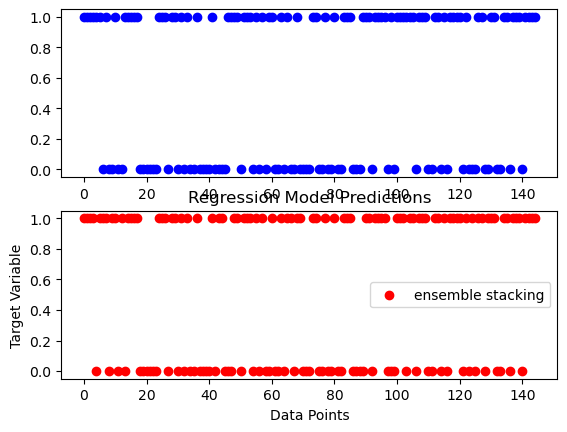

In [42]:
from mlxtend.classifier import StackingCVClassifier

sclf_model = StackingCVClassifier(classifiers=[knn_model, random_forest_model, XGBoost_model, logistic_regression_model, svm_model, decision_tree_model],
                          meta_classifier=random_forest_model)
execute_model(sclf_model, X_train, Y_train, X_test, Y_test, "ensemble stacking")

# Save

In [43]:
import pickle
filename = 'ms2 model classification.sav'
decision_tree_model.fit(X_train, Y_train)
pickle.dump(decision_tree_model, open(filename, 'wb'))